<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [0]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
 astrophysics				 lfw_dataset.py
 beheaded_inception3.py			 model_weights-HW2.pth
'Colab Notebooks'			 Train_rev1.zip
 GoogleNews-vectors-negative300.bin.gz	'video generation tasks.gsheet'
 handout.tar.gz


In [0]:
!cp '/content/gdrive/My Drive/beheaded_inception3.py' .
!cp '/content/gdrive/My Drive/handout.tar.gz' .
!tar -xzf 'handout.tar.gz'

### Data preprocessing

In [0]:
%%time
# Read Dataset
import numpy as np
import json
import copy
import matplotlib.pyplot as plt

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 217 ms, sys: 713 ms, total: 929 ms
Wall time: 939 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [0]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
#<YOUR CODE HERE>
for caps in captions:
    for cap in caps:
        word_counts.update(cap[1:-1])

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i, seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        #<YOUR CODE> 
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        #<YOUR CODE>
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True) 
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        #<YOUR CODE>
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        inits = (initial_cell[None], initial_hid[None])
        
        # compute embeddings for captions_ix
        # <YOUR CODE>
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        #<YOUR_CODE>
        
        lstm_out, _ = self.lstm(captions_emb, inits)
        
        # compute logits from lstm_out
        #<YOUR_CODE>
        logits = self.logits(lstm_out)
        
        return logits        

In [0]:
network = CaptionNet(n_tokens)

In [0]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    #<YOUR CODE>
    loss = criterion(logits_for_next.view(-1, n_tokens),
                     captions_ix_next.view(-1))
    
    return loss

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
#<YOUR CODE>
optimizer = Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, \
train_captions, val_captions = \
train_test_split(img_codes, captions, 
                 test_size=0.1, random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [0]:
generate_batch(img_codes,captions,3)

(tensor([[0.2510, 0.2802, 0.4791,  ..., 0.0174, 0.4701, 0.1314],
         [0.1085, 0.3780, 0.7068,  ..., 0.1310, 0.8733, 0.0974],
         [0.7549, 0.4580, 0.4407,  ..., 0.0724, 1.2354, 0.6846]]),
 tensor([[   1,   24,   57,   78,   35,   24,  736,   35,   77,   14,   24,  732,
            12,    2],
         [   1,   24,   47, 1475, 5699,   58, 1471,  123, 1425,   15, 1208,   12,
             2,    3],
         [   1,  112,  445,   94,   35,   24,  242, 2057,   24,  180,    2,    3,
             3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
batch_size = 64  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [0]:
val_loss_history = []
best_score = np.inf
best_model_wts = copy.deepcopy(network.state_dict())

for epoch in range(n_epochs):  
    print('EPOCH %i\n' % epoch)
    train_loss=0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        #<YOUR CODE>
        optimizer.zero_grad()
        loss_t = compute_loss(
            network, 
            *generate_batch(
                train_img_codes, 
                train_captions, 
                            batch_size))
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    val_loss_history.append(val_loss)
    print('\ttrain loss: {}, \n\tval loss: {}'.format(train_loss, val_loss))
    if val_loss < best_score:
        best_score = val_loss
        best_model_wts = copy.deepcopy(network.state_dict())

print("Finished!")


EPOCH 0

	train loss: 5.350833921432495, 
	val loss: 4.513472366333008
EPOCH 1

	train loss: 4.31887565612793, 
	val loss: 4.225768280029297
EPOCH 2

	train loss: 4.052059342861176, 
	val loss: 3.8809861660003664
EPOCH 3

	train loss: 3.84751275062561, 
	val loss: 3.7779316902160645
EPOCH 4

	train loss: 3.6709984850883486, 
	val loss: 3.491413450241089
EPOCH 5

	train loss: 3.548958761692047, 
	val loss: 3.501002311706543
EPOCH 6

	train loss: 3.4325109124183655, 
	val loss: 3.435019111633301
EPOCH 7

	train loss: 3.3499277591705323, 
	val loss: 3.2891429901123046
EPOCH 8

	train loss: 3.252963387966156, 
	val loss: 3.176770496368408
EPOCH 9

	train loss: 3.1996455144882203, 
	val loss: 3.1374342918395994
EPOCH 10

	train loss: 3.1360824704170227, 
	val loss: 3.125816249847412
EPOCH 11

	train loss: 3.1038861322402953, 
	val loss: 3.1296786785125734
EPOCH 12

	train loss: 3.065838017463684, 
	val loss: 3.067212772369385
EPOCH 13

	train loss: 3.054439218044281, 
	val loss: 3.101726913

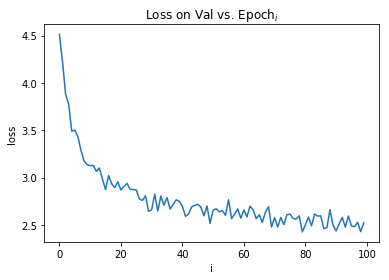

In [0]:
plt.plot(val_loss_history)
plt.title(r"Loss on Val vs. Epoch$_i$")
plt.ylabel('loss')
plt.xlabel('i');

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [0]:

from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:04<00:00, 24080891.43it/s]


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [0]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

--2019-06-20 20:17:55--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.52.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.52.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K   369KB/s    in 0.3s    

2019-06-20 20:17:56 (369 KB/s) - ‘data/img.jpg’ saved [107928/107928]



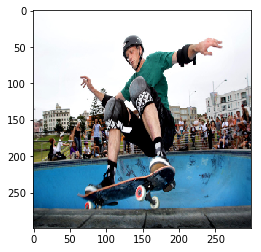

In [0]:
plt.imshow(img);

In [0]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is skateboarding on a ramp .
a man on a skateboard jumping in the air .
a man is doing a trick on a skateboard .
a man jumping up on a skateboard on a ramp .
a man on a skateboard jumping in the air .
a man riding a skateboard on a ramp .
a man on a skateboard jumping a ramp .
a man riding a skateboard on top of a ramp .
a man is doing a trick on a skateboard .
a man riding a skateboard on a ramp .


--2019-05-18 16:26:04--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.04s   

2019-05-18 16:26:04 (2.79 MB/s) - ‘data/img.jpg’ saved [106870/106870]



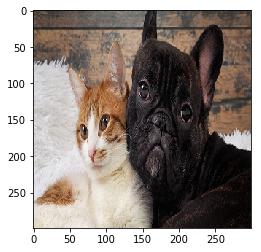

a cat is laying on a bed with a blanket .
a cat is laying on a couch with a blanket .
a cat is laying on a bed with a blanket .
a black and white cat is sitting on a couch .
a cat is laying on a couch with a book .
a cat is laying on a couch with a stuffed animal
a cat is laying on a bed with a blanket .
a cat is laying on a bed with a blanket .
a cat is sitting on a couch next to a toy .
a cat is laying on a bed in a room .


In [0]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [0]:
# apply your network on images you've found
#
#

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

--2019-05-18 16:26:31--  https://www.residentadvisor.net/photos/2012/us120317kaskad/20120317_marquee-209copy.jpg
Resolving www.residentadvisor.net (www.residentadvisor.net)... 104.20.23.69, 104.20.22.69, 2606:4700:10::6814:1745, ...
Connecting to www.residentadvisor.net (www.residentadvisor.net)|104.20.23.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216928 (212K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 211.84K  --.-KB/s    in 0.1s    

2019-05-18 16:26:32 (2.10 MB/s) - ‘data/img.jpg’ saved [216928/216928]



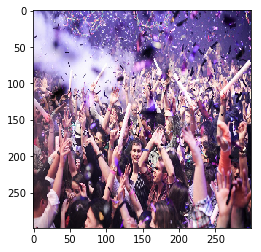

a group of people that are standing in a field .
a group of people with a soccer ball in the background .
a group of people that are standing in a field .
a group of people in a field with a frisbee .
a group of people that are standing in a field .
a group of people that are standing in a field .
a group of people in a field with a green and white cow .
a group of people standing in a field with a bunch of bananas .
a group of people that are standing in a field .
a group of people that are standing in the grass .


In [0]:
# Sth like kites is really flying in the air. At the same time, people
# hold their hands raised - let's consider this as a good example
!wget https://www.residentadvisor.net/photos/2012/us120317kaskad/20120317_marquee-209copy.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:26:42--  https://www.naukrinama.com/stressbuster/wp-content/uploads/2016/09/Why-Do-We-Always-Say-Hello-When-We-Answer-A-Call-On-Phone-The-Reason-Lies-In-This-Love-Story.jpg
Resolving www.naukrinama.com (www.naukrinama.com)... 192.124.249.157
Connecting to www.naukrinama.com (www.naukrinama.com)|192.124.249.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 606605 (592K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 592.39K   536KB/s    in 1.1s    

2019-05-18 16:26:44 (536 KB/s) - ‘data/img.jpg’ saved [606605/606605]



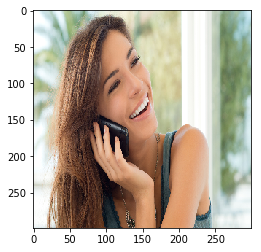

a woman talking on her cell phone .
a woman holding a cell phone in her hand .
a woman talking on her cell phone .
a woman talking on her cell phone
a woman talking on her phone while standing on a sidewalk .
a woman with a cell phone up to her ear .
a woman with a cell phone standing in front of her .
a woman is talking on her cell phone
a woman talking on her cell phone .
a woman is talking on her cell phone .


In [0]:
# The network doesn't make captions to images of women in skirts, but suggested me to try
# images of a woman with a cell phone in her hand
!wget https://www.naukrinama.com/stressbuster/wp-content/uploads/2016/09/Why-Do-We-Always-Say-Hello-When-We-Answer-A-Call-On-Phone-The-Reason-Lies-In-This-Love-Story.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:26:53--  https://neoplanodion.files.wordpress.com/2016/12/bearded.jpg
Resolving neoplanodion.files.wordpress.com (neoplanodion.files.wordpress.com)... 192.0.72.22, 192.0.72.23
Connecting to neoplanodion.files.wordpress.com (neoplanodion.files.wordpress.com)|192.0.72.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54035 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  52.77K  --.-KB/s    in 0.02s   

2019-05-18 16:26:53 (3.17 MB/s) - ‘data/img.jpg’ saved [54035/54035]



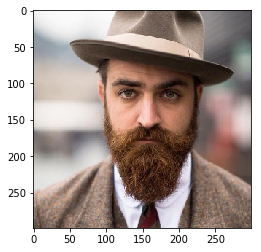

a man wearing a suit and tie standing next to a window .
a man wearing a suit and tie with a tie .
a man wearing a suit and tie and a tie .
a man wearing a suit and tie and a tie .
a man wearing a suit and tie standing next to a wall .
a man wearing a suit and tie standing next to a window .
a man wearing a suit and tie and a tie .
a man wearing a suit and tie and a tie .
a man wearing a suit and tie and a tie .
a man wearing a suit and tie and a tie .


In [0]:
# it can't extract key features (like beard and hat on this image)
!wget https://neoplanodion.files.wordpress.com/2016/12/bearded.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:27:07--  http://autokeylocksmithin.com/House,rekey,lock,autokey,.jpg
Resolving autokeylocksmithin.com (autokeylocksmithin.com)... 173.254.28.129
Connecting to autokeylocksmithin.com (autokeylocksmithin.com)|173.254.28.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 703292 (687K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 686.81K  2.30MB/s    in 0.3s    

2019-05-18 16:27:08 (2.30 MB/s) - ‘data/img.jpg’ saved [703292/703292]



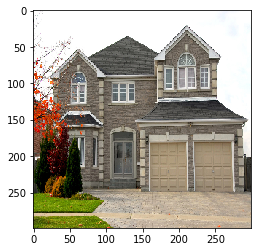

a large brick building with a clock on the top .
a large brick building with a clock on the wall .
a large brick building with a clock on the wall .
a large brick building with a clock on top .
a large brick building with a clock on the wall .
a small brick building with a clock on the wall .
a building with a clock on the wall .
a building with a clock on the wall .
a large brick building with a clock on the wall .
a large building with a clock on top of it .


In [0]:
# house is gray and rounded windows resemble a clock. It is not so bad
!wget http://autokeylocksmithin.com/House,rekey,lock,autokey,.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:27:15--  http://s1.1zoom.me/b5050/359/Surfing_Men_Waves_Water_494221_3840x2400.jpg
Resolving s1.1zoom.me (s1.1zoom.me)... 88.99.134.39
Connecting to s1.1zoom.me (s1.1zoom.me)|88.99.134.39|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4757252 (4.5M) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]   4.54M  2.87MB/s    in 1.6s    

2019-05-18 16:27:17 (2.87 MB/s) - ‘data/img.jpg’ saved [4757252/4757252]



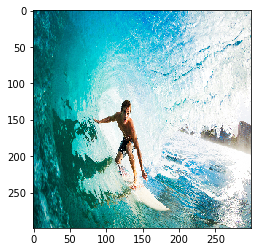

a man riding a wave on top of a surfboard .
a man riding a wave on top of a surfboard .
a man riding a wave on a surfboard .
a man riding a wave on a surfboard .
a man riding a wave on top of a surfboard .
a man riding a wave on a surfboard .
a man riding a wave on top of a surfboard .
a man riding a wave on top of a surfboard .
a man riding a wave on a surfboard .
a man riding a wave on top of a surfboard .


In [0]:
!wget http://s1.1zoom.me/b5050/359/Surfing_Men_Waves_Water_494221_3840x2400.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:27:23--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQYbSnzX6feYR28KGxQQzlwxNmCnGaZ7POXTjHyzJRhKhgZk-pTrA
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.141.102, 74.125.141.138, 74.125.141.101, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.141.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12724 (12K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  12.43K  --.-KB/s    in 0s      

2019-05-18 16:27:23 (50.6 MB/s) - ‘data/img.jpg’ saved [12724/12724]



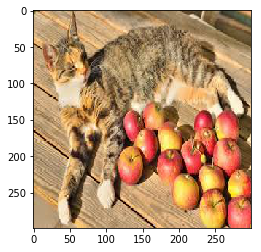

a cat is laying on a table next to a tree .
a cat is laying on a table next to a tree .
a cat is sitting on a table next to a bowl of flowers .
a cat is laying on a table next to a bowl of oranges .
a small white and gray cat is sitting on a table .
a cat is laying on a table next to a tree .
a cat is sitting on a table in a bowl .
a close up of a cat laying on a table
a small white cat is sitting on a table .
a white and gray cat is sitting on a table .


In [0]:
# Mmmmmmm
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQYbSnzX6feYR28KGxQQzlwxNmCnGaZ7POXTjHyzJRhKhgZk-pTrA -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:27:31--  https://cdn.omlet.co.uk/images/originals/Dog-Dog_Guide-A_healthy_and_happy_Golden_Retriever_splashing_around_in_the_water.jpg
Resolving cdn.omlet.co.uk (cdn.omlet.co.uk)... 13.32.80.23, 13.32.80.128, 13.32.80.90, ...
Connecting to cdn.omlet.co.uk (cdn.omlet.co.uk)|13.32.80.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82262 (80K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  80.33K   462KB/s    in 0.2s    

2019-05-18 16:27:32 (462 KB/s) - ‘data/img.jpg’ saved [82262/82262]



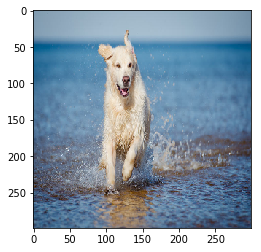

a dog is standing on a boat in the water .
a dog is standing on a boat in the water .
a dog is riding a wave on a beach .
a dog is standing on a boat in the water .
a dog is standing on a boat in the water .
a dog is standing on a boat in the water .
a dog is standing on a boat in the water .
a dog is standing on a boat in the water .
a dog is riding a horse in the water .
a dog is standing on a boat in the water .


In [0]:
!wget https://cdn.omlet.co.uk/images/originals/Dog-Dog_Guide-A_healthy_and_happy_Golden_Retriever_splashing_around_in_the_water.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:27:38--  https://avatars.mds.yandex.net/get-pdb/1105309/b26948f0-22ce-41a3-a690-770e9cbf92ce/s800
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.183, 87.250.247.182, 87.250.247.181, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140386 (137K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 137.10K   439KB/s    in 0.3s    

2019-05-18 16:27:39 (439 KB/s) - ‘data/img.jpg’ saved [140386/140386]



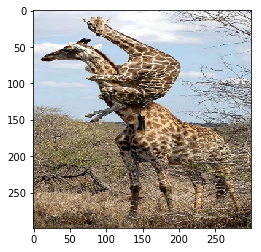

a giraffe standing in a field with trees in the background
a giraffe standing in a field with a tree in the background .
a giraffe standing in a field of grass .
a giraffe standing in a field with trees in the background .
a giraffe standing in a field next to a tree .
a giraffe standing in a field with trees in the background .
a giraffe standing in a field next to a tree .
a giraffe standing in a field with trees in the background .
a giraffe standing in the grass near a tree .
a giraffe standing next to a tree in a field .


In [0]:
# Despite that the network loves to put an object on top of other objects
# (like: cat with a cat on it, or dog), it can't solve this with giraffes, 
# since it has never meet anything similar (in case of giraffes) before
!wget https://avatars.mds.yandex.net/get-pdb/1105309/b26948f0-22ce-41a3-a690-770e9cbf92ce/s800 -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:27:45--  http://paperlief.com/images/horses-running-in-a-field-wallpaper-1.jpg
Resolving paperlief.com (paperlief.com)... 104.24.109.231, 104.24.108.231, 2606:4700:30::6818:6ce7, ...
Connecting to paperlief.com (paperlief.com)|104.24.109.231|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 782061 (764K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 763.73K  --.-KB/s    in 0.1s    

2019-05-18 16:27:45 (5.81 MB/s) - ‘data/img.jpg’ saved [782061/782061]



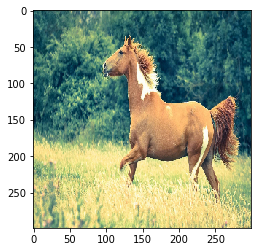

1.0
a horse standing in a field of grass .
a horse standing next to a lush green field .
a horse standing next to a lush green field .
a horse standing in a field with a dog .
a horse standing on top of a lush green field .
a horse standing next to a lush green field .
a horse standing in a field with a man in the background .
a horse standing next to a lush green field .
a horse standing in a field with a dog .
a horse standing in a field with a cow .


In [0]:
# 50 / 50 - no man in the background, but the rest is good
!wget http://paperlief.com/images/horses-running-in-a-field-wallpaper-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:27:52--  https://www.zastavki.com/pictures/originals/2014/Winter_The_road_through_the_forest_087391_.jpg
Resolving www.zastavki.com (www.zastavki.com)... 144.76.98.114
Connecting to www.zastavki.com (www.zastavki.com)|144.76.98.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6401779 (6.1M) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]   6.10M  2.29MB/s    in 2.7s    

2019-05-18 16:27:56 (2.29 MB/s) - ‘data/img.jpg’ saved [6401779/6401779]



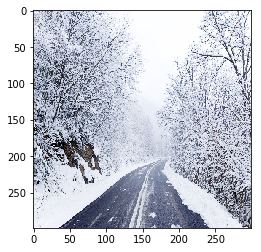

a person on a ski slope with a mountain in the background .
a snowy mountain with a tree and a mountain range .
a person is skiing down a hill on a ski slope .
a person riding a snow board on a snowy surface
a snow covered mountain with a large mountain range .
a person riding a snowboard down a snowy hill .
a person on a snowboard in the snow .
a person riding a snowboard down a hill .
a person riding a snowboard down a hill .
a person riding a snowboard down a hill .


In [0]:
# Fail
!wget https://www.zastavki.com/pictures/originals/2014/Winter_The_road_through_the_forest_087391_.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:28:02--  https://www.dreuz.info/wp-content/uploads/2016/12/subway.jpg
Resolving www.dreuz.info (www.dreuz.info)... 104.24.121.7, 104.24.120.7
Connecting to www.dreuz.info (www.dreuz.info)|104.24.121.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667093 (651K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 651.46K  1.58MB/s    in 0.4s    

2019-05-18 16:28:03 (1.58 MB/s) - ‘data/img.jpg’ saved [667093/667093]



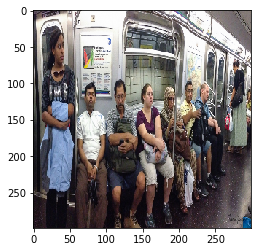

a group of people standing next to each other on a bus .
a woman and a woman are standing next to a woman .
a group of people standing around a bus .
a group of people standing next to each other on a cell phone .
a group of people standing next to each other .
a woman and a woman are standing next to a man .
a woman and a woman are standing next to each other .
a group of people standing next to each other on a cell phone .
a woman and a woman are standing next to a bus .
a group of people standing next to each other .


In [0]:
# red and white umbrellas
!wget https://www.dreuz.info/wp-content/uploads/2016/12/subway.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-18 16:28:10--  http://1.bp.blogspot.com/-wbRfDaHp5ps/UOpw4AbtAGI/AAAAAAAAN5I/squvr29hcLw/s1600/Funny+Dog+Playing+Piano_7.jpg
Resolving 1.bp.blogspot.com (1.bp.blogspot.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to 1.bp.blogspot.com (1.bp.blogspot.com)|74.125.141.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39225 (38K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  38.31K  --.-KB/s    in 0s      

2019-05-18 16:28:10 (390 MB/s) - ‘data/img.jpg’ saved [39225/39225]



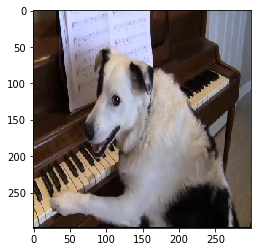

a dog laying on a bed with a remote control .
a dog laying on top of a white couch .
a dog laying on a bed with a white blanket .
a dog laying on a bed in a room .
a dog laying on a couch with a frisbee in its mouth .
a dog is laying on a bench
a dog laying on a bed with a remote control .
a dog laying on a bed with a white blanket .
a dog laying on a bed with a remote control .
a dog laying on a couch with a remote control .


In [0]:
!wget http://1.bp.blogspot.com/-wbRfDaHp5ps/UOpw4AbtAGI/AAAAAAAAN5I/squvr29hcLw/s1600/Funny+Dog+Playing+Piano_7.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img, dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))